# **Import Dependencies**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install detecto

In [3]:
!pip install tensorflow==2.13.0
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 45.8 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid

import keras
import tensorflow as tf

from keras.models import Sequential, Model
import tensorflow.keras.models as Models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras import backend as K
import tensorflow.keras.layers as Layers
import tensorflow.keras.metrics as Metrics

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras import Model

!pip install gdown
!pip install ipython-autotime #Time Execution
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.8 MB/s eta 0:00:00
time: 520 µs (started: 2023-12-04 08:08:42 +00:00)


# **Object Detection + Classification Process**

In [5]:
#Import object detection Model
model_od = core.Model.load('/content/drive/MyDrive/Capstone/Model/v10 faster rcnn batch size 2 (0.96).pth', ['Biji Kopi', 'Kopi Gelondong'])

#Import Classification Model
model_clf = keras.models.load_model('/content/drive/MyDrive/Capstone-v10/model_mobileNet_100_rlr.h5')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 67.7MB/s]


time: 18.8 s (started: 2023-12-04 08:08:54 +00:00)


In [6]:
reverse_mapping_col = {
    0: (255, 255, 0),  # Bentuk Tidak Wajar (Kuning)
    1: (0, 0, 0),      # Kelainan Lain (Hitam)
    2: (0, 255, 0),    # Normal (Hijau)
    3: (255, 0, 0),    # Warna Tidak Wajar (Merah)
}

def mapper_col(value):
    return reverse_mapping_col[value]

reverse_mapping = {
    0: 'Bentuk Tidak Wajar',
    1: 'Kelainan Lain',
    2: 'Normal',
    3: 'Warna Tidak Wajar'
}

def mapper(value):
    return reverse_mapping[value]

time: 1.06 ms (started: 2023-12-04 08:09:19 +00:00)


1/1 [==============================] - 0s 93ms/step


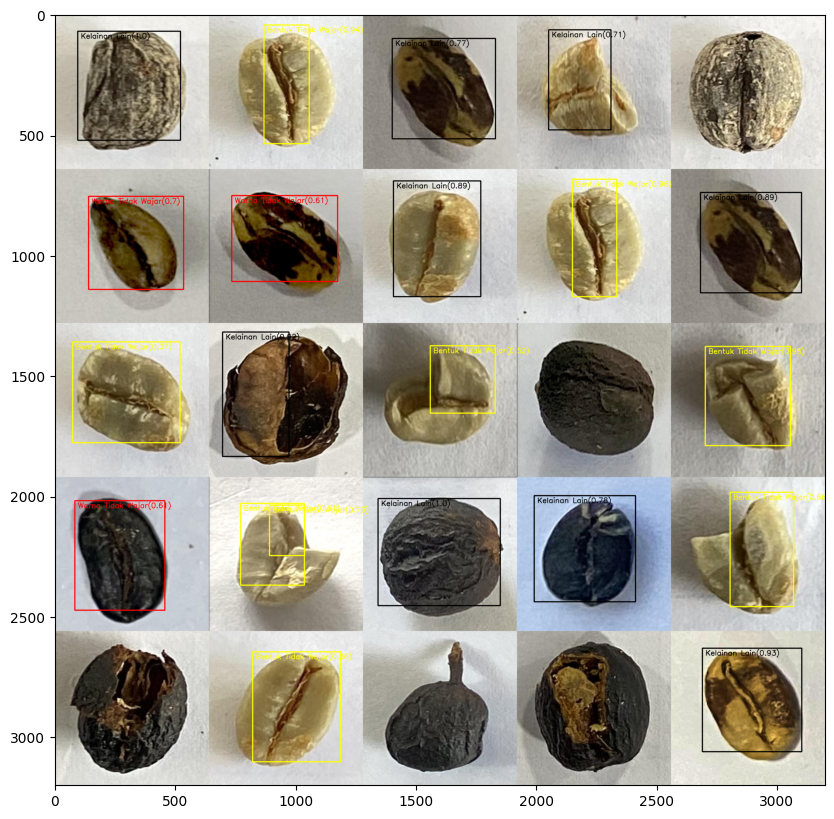

time: 20.6 s (started: 2023-12-04 08:09:38 +00:00)


In [7]:
import cv2
from google.colab.patches import cv2_imshow

thresh = 0.5  # Threshold untuk mengontrol sejauh mana hasil deteksi diterima

# Membaca gambar dari file
image_ = utils.read_image('/content/drive/MyDrive/Capstone/image.jpg')

# Melakukan prediksi objek pada gambar menggunakan model objek deteksi (model_od)
predictions = model_od.predict(image_)
labels, boxes, scores = predictions

# Mencari indeks dari prediksi yang memiliki skor lebih tinggi dari threshold
filtered_indices = np.where(scores > thresh)

# Mengambil kotak deteksi yang lolos filter
filtered_boxes = boxes[filtered_indices]

# Memproses setiap kotak deteksi yang lolos filter
area = filtered_boxes.numpy()
result = []

for a in area:
    # Mendapatkan koordinat kotak deteksi
    xmin = np.floor(a[0]).astype(int)
    ymin = np.floor(a[1]).astype(int)
    xmax = np.floor(a[2]).astype(int)
    ymax = np.floor(a[3]).astype(int)

    # Memotong bagian gambar sesuai dengan kotak deteksi
    crop_img = image_[ymin:ymax, xmin:xmax]

    # Menyimpan potongan gambar ke file sementara
    cv2.imwrite("/content/temp.png", crop_img)

    # Memuat gambar dari file sementara dan menyesuaikannya ke ukuran yang diinginkan
    img_ = load_img("/content/temp.png", target_size=(224, 224))
    image = img_to_array(img_)

    # Memprediksi jenis objek dalam potongan gambar menggunakan model klasifikasi (model_clf)
    prediction_image = np.array(crop_img)
    prediction_image = np.expand_dims(image, axis=0)
    prediction = model_clf.predict(prediction_image)

    # Mendapatkan nilai tertinggi dari prediksi dan indeks kelas yang sesuai
    score = round(np.max(prediction), 2)
    value = np.argmax(prediction)

    # Menambahkan hasil prediksi ke dalam daftar hasil
    result.append(value)

    # Membuat label untuk kotak deteksi dengan jenis objek dan skornya
    label = mapper(value) + "(" + str(score) + ")"

    # Menampilkan label dan kotak deteksi pada gambar
    #cv2.putText(image_, label, (xmin + 13, ymin + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, mapper_col(value), 2)
    #cv2.rectangle(image_, (xmin, ymin), (xmax, ymax), mapper_col(value), 3)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1  # Ukuran font yang lebih besar
    font_thickness = 2  # Ketebalan font yang lebih tebal
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = xmin + 13
    text_y = ymin + 30

    # Tambahkan label dengan font yang lebih besar dan tebal
    cv2.putText(image_, label, (text_x, text_y),
                font, font_scale, mapper_col(value), font_thickness)
    cv2.rectangle(image_, (xmin, ymin), (xmax, ymax), mapper_col(value), 3)


# Menampilkan gambar asli dengan kotak deteksi dan label
fig = plt.figure(figsize=(10, 10))
plt.imshow(image_)

1/1 [==============================] - 0s 49ms/step


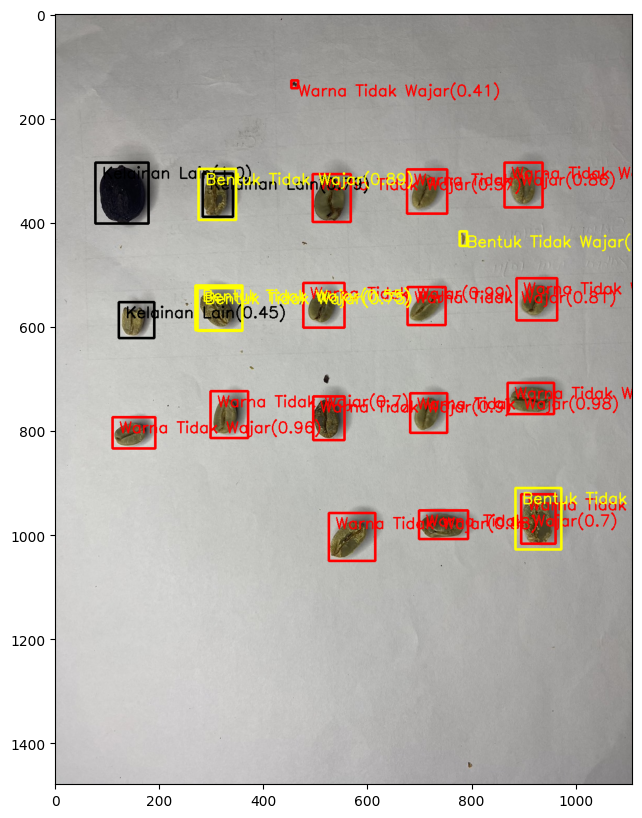

time: 13.2 s (started: 2023-12-04 08:10:59 +00:00)


In [8]:
import cv2
from google.colab.patches import cv2_imshow

thresh = 0.5  # Threshold untuk mengontrol sejauh mana hasil deteksi diterima

# Membaca gambar dari file
image_ = utils.read_image('/content/drive/MyDrive/Capstone/S__13066243.jpg')

# Melakukan prediksi objek pada gambar menggunakan model objek deteksi (model_od)
predictions = model_od.predict(image_)
labels, boxes, scores = predictions

# Mencari indeks dari prediksi yang memiliki skor lebih tinggi dari threshold
filtered_indices = np.where(scores > thresh)

# Mengambil kotak deteksi yang lolos filter
filtered_boxes = boxes[filtered_indices]

# Memproses setiap kotak deteksi yang lolos filter
area = filtered_boxes.numpy()
result = []

for a in area:
    # Mendapatkan koordinat kotak deteksi
    xmin = np.floor(a[0]).astype(int)
    ymin = np.floor(a[1]).astype(int)
    xmax = np.floor(a[2]).astype(int)
    ymax = np.floor(a[3]).astype(int)

    # Memotong bagian gambar sesuai dengan kotak deteksi
    crop_img = image_[ymin:ymax, xmin:xmax]

    # Menyimpan potongan gambar ke file sementara
    cv2.imwrite("/content/temp.png", crop_img)

    # Memuat gambar dari file sementara dan menyesuaikannya ke ukuran yang diinginkan
    img_ = load_img("/content/temp.png", target_size=(224, 224))
    image = img_to_array(img_)

    # Memprediksi jenis objek dalam potongan gambar menggunakan model klasifikasi (model_clf)
    prediction_image = np.array(crop_img)
    prediction_image = np.expand_dims(image, axis=0)
    prediction = model_clf.predict(prediction_image)

    # Mendapatkan nilai tertinggi dari prediksi dan indeks kelas yang sesuai
    score = round(np.max(prediction), 2)
    value = np.argmax(prediction)

    # Menambahkan hasil prediksi ke dalam daftar hasil
    result.append(value)

    # Membuat label untuk kotak deteksi dengan jenis objek dan skornya
    label = mapper(value) + "(" + str(score) + ")"

    # Menampilkan label dan kotak deteksi pada gambar
    #cv2.putText(image_, label, (xmin + 13, ymin + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, mapper_col(value), 2)
    #cv2.rectangle(image_, (xmin, ymin), (xmax, ymax), mapper_col(value), 3)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1  # Ukuran font yang lebih besar
    font_thickness = 2  # Ketebalan font yang lebih tebal
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = xmin + 13
    text_y = ymin + 30

    # Tambahkan label dengan font yang lebih besar dan tebal
    cv2.putText(image_, label, (text_x, text_y),
                font, font_scale, mapper_col(value), font_thickness)
    cv2.rectangle(image_, (xmin, ymin), (xmax, ymax), mapper_col(value), 3)


# Menampilkan gambar asli dengan kotak deteksi dan label
fig = plt.figure(figsize=(10, 10))
plt.imshow(image_)

1/1 [==============================] - 0s 75ms/step


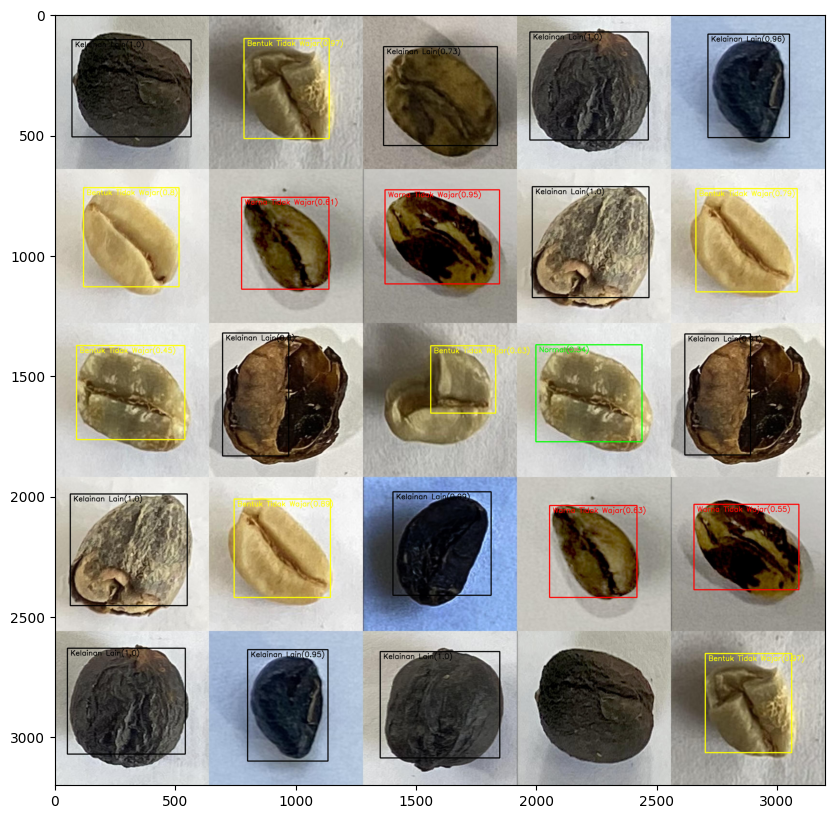

time: 18.7 s (started: 2023-11-16 17:37:26 +00:00)


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

thresh = 0.5  # Threshold untuk mengontrol sejauh mana hasil deteksi diterima

# Membaca gambar dari file
image_ = utils.read_image('/content/drive/MyDrive/Capstone/merged.jpg')

# Melakukan prediksi objek pada gambar menggunakan model objek deteksi (model_od)
predictions = model_od.predict(image_)
labels, boxes, scores = predictions

# Mencari indeks dari prediksi yang memiliki skor lebih tinggi dari threshold
filtered_indices = np.where(scores > thresh)

# Mengambil kotak deteksi yang lolos filter
filtered_boxes = boxes[filtered_indices]

# Memproses setiap kotak deteksi yang lolos filter
area = filtered_boxes.numpy()
result = []

for a in area:
    # Mendapatkan koordinat kotak deteksi
    xmin = np.floor(a[0]).astype(int)
    ymin = np.floor(a[1]).astype(int)
    xmax = np.floor(a[2]).astype(int)
    ymax = np.floor(a[3]).astype(int)

    # Memotong bagian gambar sesuai dengan kotak deteksi
    crop_img = image_[ymin:ymax, xmin:xmax]

    # Menyimpan potongan gambar ke file sementara
    cv2.imwrite("/content/temp.png", crop_img)

    # Memuat gambar dari file sementara dan menyesuaikannya ke ukuran yang diinginkan
    img_ = load_img("/content/temp.png", target_size=(224, 224))
    image = img_to_array(img_)

    # Memprediksi jenis objek dalam potongan gambar menggunakan model klasifikasi (model_clf)
    prediction_image = np.array(crop_img)
    prediction_image = np.expand_dims(image, axis=0)
    prediction = model_clf.predict(prediction_image)

    # Mendapatkan nilai tertinggi dari prediksi dan indeks kelas yang sesuai
    score = round(np.max(prediction), 2)
    value = np.argmax(prediction)

    # Menambahkan hasil prediksi ke dalam daftar hasil
    result.append(value)

    # Membuat label untuk kotak deteksi dengan jenis objek dan skornya
    label = mapper(value) + "(" + str(score) + ")"

    # Menampilkan label dan kotak deteksi pada gambar
    #cv2.putText(image_, label, (xmin + 13, ymin + 30), cv2.FONT_HERSHEY_SIMPLEX, 1, mapper_col(value), 2)
    #cv2.rectangle(image_, (xmin, ymin), (xmax, ymax), mapper_col(value), 3)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1  # Ukuran font yang lebih besar
    font_thickness = 2  # Ketebalan font yang lebih tebal
    text_size = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
    text_x = xmin + 13
    text_y = ymin + 30

    # Tambahkan label dengan font yang lebih besar dan tebal
    cv2.putText(image_, label, (text_x, text_y),
                font, font_scale, mapper_col(value), font_thickness)
    cv2.rectangle(image_, (xmin, ymin), (xmax, ymax), mapper_col(value), 3)


# Menampilkan gambar asli dengan kotak deteksi dan label
fig = plt.figure(figsize=(10, 10))
plt.imshow(image_)